In [1]:
import numpy as np
import pandas as pd

from astropy import coordinates
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
import astroquery
from astroquery.irsa import Irsa
from astroquery.vizier import Vizier
from astropy.table import Table, join

Irsa.ROW_LIMIT = -1
Vizier.ROW_LIMIT = -1

import matplotlib.pyplot as plt

%matplotlib inline

# Get the data

In [2]:
obj = ["3C 454.3", 343.49062, 16.14821, 4./60.]
# name, ra, dec, radius of cone
obj_name = obj[0]
obj_ra   = obj[1]
obj_dec  = obj[2]
cone_radius  = obj[3]

In [3]:
obj_coord = coordinates.SkyCoord(ra=obj_ra, dec=obj_dec, unit=(u.deg, u.deg), frame="icrs")

In [4]:
data_2mass = Irsa.query_region(obj_coord, catalog="fp_psc", radius=cone_radius * u.deg)
data_wise  = Irsa.query_region(obj_coord, catalog="allwise_p3as_psd", radius=cone_radius * u.deg)
__data_galex = Vizier.query_region(obj_coord, catalog='II/335', radius=cone_radius * u.deg)
data_galex = __data_galex[0]

In [5]:
num_2mass = len(data_2mass)
num_wise  = len(data_wise)
num_galex = len(data_galex)

print("Number of object in (2MASS, WISE, GALEX): ", num_2mass, num_wise, num_galex)

Number of object in (2MASS, WISE, GALEX):  44 218 41


# Matching coordinates (3 Catalogs)

In [6]:
ra_2mass = data_2mass['ra']
dec_2mass = data_2mass['dec']
c_2mass = coordinates.SkyCoord(ra=ra_2mass, dec=dec_2mass, unit=(u.deg, u.deg), frame="icrs")

ra_wise  = data_wise['ra']
dec_wise = data_wise['dec']
c_wise = coordinates.SkyCoord(ra=ra_wise, dec=dec_wise, unit=(u.deg, u.deg), frame="icrs")

ra_galex  = data_galex['RAJ2000']
dec_galex = data_galex['DEJ2000']
c_galex = coordinates.SkyCoord(ra=ra_galex, dec=dec_galex, unit=(u.deg, u.deg), frame="icrs")

In [7]:
sep_min = 2.5 * u.arcsec # minimum separation in arcsec

In [8]:
idx_2mass, idx_wise, d2d, d3d = c_wise.search_around_sky(c_2mass, sep_min)
c_2mass_wise = c_2mass[idx_2mass]
print("Only 2MASS and WISE: ", len(idx_2mass))

Only 2MASS and WISE:  41


# Plot W1-J vs W1

In [9]:
# from matching of 2 cats (2MASS and WISE) coordinate
w1 = data_wise[idx_wise]['w1mpro']
j = data_2mass[idx_2mass]['j_m']
w1j = w1-j

# match between WISE and 2MASS
data_wise_2mass = data_wise[idx_wise] # WISE dataset

galaxy = data_wise_2mass[w1j<-1.7] # https://academic.oup.com/mnras/article/448/2/1305/1055284

In [10]:
galaxy

designation,ra,dec,clon,clat,sigra,sigdec,sigradec,w1mpro,w1sigmpro,w1snr,w1rchi2,w2mpro,w2sigmpro,w2snr,w2rchi2,w3mpro,w3sigmpro,w3snr,w3rchi2,w4mpro,w4sigmpro,w4snr,w4rchi2,nb,na,w1sat,w2sat,w3sat,w4sat,pmra,sigpmra,pmdec,sigpmdec,cc_flags,ext_flg,var_flg,ph_qual,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m,dist,angle,id
,deg,deg,,,arcs,arcs,arcs,mag,mag,,,mag,mag,,,mag,mag,,,mag,mag,,,,,,,,,maspyr,maspyr,maspyr,maspyr,,,,,,,,,,,,,,arcs,deg,
object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,int32,int32,int32,object,int32,object,object,object,int32,int32,int32,int32,int32,int32,int32,int32,float64,float64,object
J225357.74+160853.7,343.491,16.148,22h53m57.75s,16d08m53.70s,0.0287,0.027,-0.0023,9.263,0.021,50.9,23.17,8.147,0.019,57.6,31.03,5.801,0.013,82.7,2.789,3.387,0.02,54.3,1.135,1,0,0.0,0.0,0.0,0.0,-247,59,22,36,0000,1,9964,AAAA,1100,24,24,24,24,13,13,13,13,0.147404,349.046251,0
J225350.60+160943.7,343.461,16.162,22h53m50.60s,16d09m43.74s,0.0643,0.0649,-0.0079,14.254,0.029,37.2,3.148,14.053,0.045,24.0,1.046,10.68,0.098,11.0,1.087,8.813,0.464,2.3,0.9725,1,0,0.0,0.0,0.0,0.0,68,196,-437,208,000d,1,000n,AAAC,1100,25,25,24,24,8,13,0,13,114.54805,295.984733,56


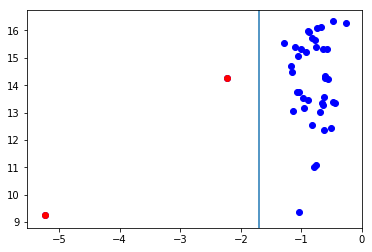

In [11]:
plt.scatter(w1j, w1, color='blue')
for i, name in enumerate(data_wise_2mass['designation']):
    for galaxyname in galaxy['designation']:
        if name == galaxyname:
            plt.scatter(w1j[i], w1[i], color="red")  
            
plt.axvline(x=-1.7) # https://academic.oup.com/mnras/article/448/2/1305/1055284

- W1-J < -1.7 => galaxy
- W1-J > -1.7 => stars

only 2 object are galaxy?

In [12]:
# + GALEX
___idx_2mass_wise_galex, idx_galex, d2d, d3d = c_galex.search_around_sky(c_2mass_wise, sep_min)

match_all_coord = c_galex[idx_galex]
print("Match all 3 cats: ", len(match_all_coord))

Match all 3 cats:  14


# Filter

In [13]:
### GALEX data which match with 2MASS and WISE!
match_galex = data_galex[idx_galex]
match_galex

RAJ2000,DEJ2000,r.fov,b,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fr,Nr
deg,deg,deg,,mag,mag,mag,mag,,,,,deg,deg
float64,float64,float64,uint8,float64,float32,float64,float32,int16,int16,int16,int16,float64,float64
343.490512,16.148415,0.358822,3,17.9253,0.0534,16.9360,0.0167,0,0,0,0,0.001527,0.001446
343.499738,16.165088,0.343000,1,--,--,22.8185,0.4343,0,0,0,0,--,0.002056
343.479534,16.119063,0.387521,1,--,--,20.3866,0.1014,0,0,0,0,--,0.002548
343.460686,16.162162,0.344095,3,21.4604,0.3460,20.4761,0.1450,0,0,0,0,0.002226,0.007870
343.520690,16.129548,0.380778,1,--,--,22.1891,0.4842,0,0,0,0,--,0.004134
343.436123,16.152472,0.354704,1,--,--,22.4452,0.4019,0,0,0,0,--,0.002512
343.434288,16.135523,0.371737,1,--,--,22.1046,0.3953,0,0,0,0,--,0.004224
343.462729,16.098788,0.407463,1,--,--,20.2440,0.0928,0,1,0,0,--,0.001539


In [14]:
idx_2mass, idx, d2d, d3d = match_all_coord.search_around_sky(c_2mass, sep_min)
match_2mass = data_2mass[idx_2mass]
match_2mass

ra,dec,clon,clat,err_maj,err_min,err_ang,designation,j_m,j_cmsig,j_msigcom,j_snr,h_m,h_cmsig,h_msigcom,h_snr,k_m,k_cmsig,k_msigcom,k_snr,ph_qual,rd_flg,bl_flg,cc_flg,ndet,gal_contam,mp_flg,hemis,xdate,scan,glon,glat,a,dist_opt,phi_opt,b_m_opt,vr_m_opt,nopt_mchs,ext_key,dist,angle,j_h,h_k,j_k,id
deg,deg,,,arcs,arcs,deg,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,,,,,,,,,,,deg,deg,,arcs,deg,mag,mag,,,arcs,deg,,,,
float64,float64,object,object,float64,float64,int32,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,int32,int32,object,object,int32,float64,float64,object,float64,int32,float64,float64,int32,int32,float64,float64,float64,float64,float64,object
343.491,16.148,22h53m57.75s,16d08m53.63s,0.07,0.06,90,22535774+1608536,14.494,0.027,0.03,61.6,13.855,0.029,0.03,52.7,13.061,0.026,0.027,55.9,AAA,222,111,000,665566,0,0,n,1998-10-01,73,86.111,-38.184,U,0.0,115,14.8,14.1,1,--,0.072344,5.486687,0.639,0.794,1.433,0
343.500,16.165,22h53m59.94s,16d09m54.03s,0.07,0.06,90,22535994+1609540,14.215,0.025,0.028,79.7,13.795,0.026,0.027,55.7,13.641,0.046,0.047,32.7,AAA,222,111,000,666666,0,0,n,1998-10-01,73,86.132,-38.175,U,0.7,77,16.4,15.4,1,--,68.22223,27.579842,0.42,0.154,0.574,7
343.480,16.119,22h53m55.12s,16d07m08.40s,0.07,0.06,90,22535512+1607083,13.817,0.02,0.024,115.0,13.437,0.026,0.027,77.5,13.407,0.036,0.037,40.6,AAA,222,111,000,666666,0,0,n,1998-10-01,73,86.079,-38.202,U,1.0,128,15.7,14.5,1,--,111.754579,199.783553,0.38,0.03,0.41,12
343.461,16.162,22h53m50.61s,16d09m42.97s,0.22,0.19,100,22535061+1609429,16.475,0.148,0.149,9.9,15.667,0.139,0.139,9.9,15.295,0.179,0.179,7.1,BBC,222,111,000,363526,0,0,n,1998-10-01,73,86.091,-38.156,U,0.5,193,16.5,16.0,2,810608,114.107665,295.665011,0.808,0.372,1.18,13
343.520,16.130,22h54m04.87s,16d07m46.75s,0.08,0.06,0,22540487+1607467,14.012,0.019,0.023,96.1,13.466,0.026,0.027,78.1,13.316,0.034,0.035,44.2,AAA,222,111,000,666666,0,0,n,1998-10-01,74,86.128,-38.215,U,0.3,177,16.3,15.2,1,--,122.49451,123.048039,0.546,0.15,0.696,14
343.436,16.152,22h53m44.64s,16d09m07.89s,0.07,0.06,90,22534464+1609078,12.992,0.019,0.022,245.8,12.524,0.023,0.024,179.6,12.443,0.017,0.019,98.7,AAA,222,111,000,664466,0,0,n,1998-10-01,73,86.058,-38.151,U,0.3,138,15.5,14.3,1,--,189.384005,274.347592,0.468,0.081,0.549,23
343.434,16.135,22h53m44.20s,16d08m06.36s,0.07,0.06,90,22534420+1608063,14.803,0.031,0.034,46.4,14.423,0.042,0.043,31.2,14.452,0.076,0.076,15.5,AAA,222,111,000,666606,0,0,n,1998-10-01,73,86.044,-38.165,U,0.4,224,16.4,15.6,1,--,200.831987,256.41714,0.38,-0.029,0.351,26
343.463,16.099,22h53m51.04s,16d05m54.91s,0.07,0.06,90,22535103+1605549,12.945,0.017,0.021,256.7,12.558,0.017,0.019,174.1,12.445,0.021,0.023,98.5,AAA,222,111,000,664466,0,0,n,1998-10-01,73,86.048,-38.21,U,0.3,122,14.8,14.0,1,--,203.161969,208.440116,0.387,0.113,0.5,27


In [15]:
idx_wise, idx, d2d, d3d = match_all_coord.search_around_sky(c_wise, sep_min)
match_wise = data_wise[idx_wise]
match_wise

designation,ra,dec,clon,clat,sigra,sigdec,sigradec,w1mpro,w1sigmpro,w1snr,w1rchi2,w2mpro,w2sigmpro,w2snr,w2rchi2,w3mpro,w3sigmpro,w3snr,w3rchi2,w4mpro,w4sigmpro,w4snr,w4rchi2,nb,na,w1sat,w2sat,w3sat,w4sat,pmra,sigpmra,pmdec,sigpmdec,cc_flags,ext_flg,var_flg,ph_qual,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m,dist,angle,id
,deg,deg,,,arcs,arcs,arcs,mag,mag,,,mag,mag,,,mag,mag,,,mag,mag,,,,,,,,,maspyr,maspyr,maspyr,maspyr,,,,,,,,,,,,,,arcs,deg,
object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,int32,int32,int32,object,int32,object,object,object,int32,int32,int32,int32,int32,int32,int32,int32,float64,float64,object
J225357.74+160853.7,343.491,16.148,22h53m57.75s,16d08m53.70s,0.0287,0.027,-0.0023,9.263,0.021,50.9,23.17,8.147,0.019,57.6,31.03,5.801,0.013,82.7,2.789,3.387,0.02,54.3,1.135,1,0,0.0,0.0,0.0,0.0,-247,59,22,36,0000,1,9964,AAAA,1100,24,24,24,24,13,13,13,13,0.147404,349.046251,0
J225359.94+160953.9,343.500,16.165,22h53m59.95s,16d09m53.97s,0.0512,0.0505,-0.0057,13.587,0.025,43.4,1.025,13.615,0.032,33.8,0.9313,12.577,--,-0.9,0.9551,9.076,--,-2.5,0.8342,1,0,0.0,0.0,0.0,0.0,-17,98,-81,99,0h0d,0,00nn,AAUU,1100,25,25,25,25,0,14,0,14,68.220268,27.679694,17
J225355.13+160708.1,343.480,16.119,22h53m55.14s,16d07m08.13s,0.0508,0.0496,-0.0064,13.367,0.025,43.3,1.144,13.373,0.031,34.8,0.9093,11.923,0.341,3.2,0.9579,8.375,--,2.0,0.9141,1,0,0.0,0.0,0.0,0.004,-101,91,45,90,000d,0,00nn,AABU,1100,26,26,26,26,0,12,0,13,111.940272,199.650476,53
J225350.60+160943.7,343.461,16.162,22h53m50.60s,16d09m43.74s,0.0643,0.0649,-0.0079,14.254,0.029,37.2,3.148,14.053,0.045,24.0,1.046,10.68,0.098,11.0,1.087,8.813,0.464,2.3,0.9725,1,0,0.0,0.0,0.0,0.0,68,196,-437,208,000d,1,000n,AAAC,1100,25,25,24,24,8,13,0,13,114.54805,295.984733,56
J225404.87+160746.7,343.520,16.130,22h54m04.88s,16d07m46.74s,0.0494,0.05,0.0001,13.357,0.025,43.4,0.927,13.407,0.031,35.1,1.052,12.086,--,1.1,0.9689,9.198,--,-1.0,0.9408,1,0,0.0,0.0,0.0,0.0,0,87,0,90,0000,0,00nn,AAUU,1100,24,24,24,24,1,12,0,12,122.526853,123.042816,59
J225344.64+160907.8,343.436,16.152,22h53m44.64s,16d09m07.83s,0.0443,0.0432,0.0065,12.368,0.025,43.6,1.231,12.397,0.024,45.1,0.9976,11.977,0.279,3.9,1.138,8.484,--,1.7,0.9392,1,0,0.0,0.0,0.0,0.0,-82,59,11,60,0000,0,00nn,AABU,1100,27,27,26,26,2,15,0,15,189.372069,274.328968,139
J225344.19+160806.2,343.434,16.135,22h53m44.19s,16d08m06.29s,0.0658,0.066,-0.011,14.241,0.029,37.2,0.9327,14.295,0.046,23.5,0.9391,11.889,--,1.8,0.7729,9.199,--,-2.0,0.8407,1,0,0.0,0.0,0.0,0.0,-124,152,60,155,0000,0,11nn,AAUU,1100,25,25,24,25,0,14,0,14,200.944968,256.403916,155
J225351.03+160554.7,343.463,16.099,22h53m51.04s,16d05m54.76s,0.0434,0.0421,0.0066,12.431,0.024,46.0,1.286,12.454,0.024,44.6,1.156,11.949,0.276,3.9,0.8234,8.981,--,0.2,0.9719,1,0,0.0,0.001,0.0,0.0,10,61,26,60,0000,0,00nn,AABU,1100,25,25,25,25,1,13,0,13,203.265143,208.409629,160


## Join table

In [16]:
# joindata = Table([match_2mass['j_m'], 
#                   match_2mass['j_m']-match_2mass['h_m'], 
#                   match_2mass['j_m']-match_2mass['k_m'],
#                   match_2mass['j_m']-match_wise['w1mpro'], 
#                   match_2mass['j_m']-match_wise['w2mpro'],
#                   match_2mass['j_m']-match_wise['w3mpro'],
#                   match_2mass['j_m']-match_wise['w4mpro'],
#                   match_2mass['j_m']-match_galex['NUVmag']], 
#                   names=('J', 'J-H', 'J-K', 'J-W1', 'J-W2', 'J-W3', 'J-W4', 'J-NUV'))

In [17]:
joindata = np.array([match_2mass['j_m'], 
                  match_2mass['j_m']-match_2mass['h_m'], 
                  match_2mass['j_m']-match_2mass['k_m'],
                  match_2mass['j_m']-match_wise['w1mpro'], 
                  match_2mass['j_m']-match_wise['w2mpro'],
                  match_2mass['j_m']-match_wise['w3mpro'],
                  match_2mass['j_m']-match_wise['w4mpro'],
                  match_2mass['j_m']-match_galex['NUVmag']])

joindata = joindata.T

In [18]:
joindata

array([[ 14.494 ,   0.639 ,   1.433 ,   5.231 ,   6.347 ,   8.693 ,
         11.107 ,  -2.442 ],
       [ 14.215 ,   0.42  ,   0.574 ,   0.628 ,   0.6   ,   1.638 ,
          5.139 ,  -8.6035],
       [ 13.817 ,   0.38  ,   0.41  ,   0.45  ,   0.444 ,   1.894 ,
          5.442 ,  -6.5696],
       [ 16.475 ,   0.808 ,   1.18  ,   2.221 ,   2.422 ,   5.795 ,
          7.662 ,  -4.0011],
       [ 14.012 ,   0.546 ,   0.696 ,   0.655 ,   0.605 ,   1.926 ,
          4.814 ,  -8.1771],
       [ 12.992 ,   0.468 ,   0.549 ,   0.624 ,   0.595 ,   1.015 ,
          4.508 ,  -9.4532],
       [ 14.803 ,   0.38  ,   0.351 ,   0.562 ,   0.508 ,   2.914 ,
          5.604 ,  -7.3016],
       [ 12.945 ,   0.387 ,   0.5   ,   0.514 ,   0.491 ,   0.996 ,
          3.964 ,  -7.299 ],
       [ 13.878 ,   0.365 ,   0.465 ,   0.476 ,   0.433 ,   1.362 ,
          4.761 ,  -7.9779],
       [ 14.95  ,   0.449 ,   0.551 ,   0.606 ,   0.482 ,   2.237 ,
          5.986 ,  -7.1068],
       [ 15.964 ,   0.516 ,   

# Analysis

### PCA

In [19]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = scale(joindata)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

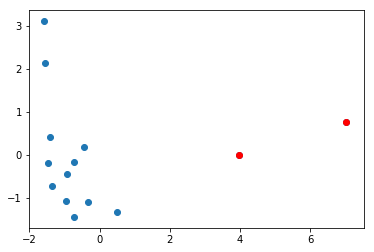

In [20]:
plt.scatter(X_r[:,0], X_r[:,1])
for i, name in enumerate(match_wise['designation']):
    for galaxyname in galaxy['designation']:
        if name == galaxyname:
            plt.scatter(X_r[i,0], X_r[i,1], color="red")  

### DBSCAN

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = scale(joindata)

db = DBSCAN(eps=2, min_samples=3).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print(labels)

Estimated number of clusters: 1
[-1  0  0 -1  0  0  0  0  0  0  0  0  0  0]


#### Plot J-W1 vs J

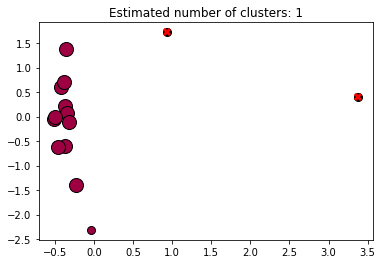

In [22]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    
    ## J vs J-W1
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 3], xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 3], xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=8)
    
    for i, name in enumerate(match_wise['designation']):
        for galaxyname in galaxy['designation']:
            if name == galaxyname:
                plt.plot(X[i,3], X[i,0], marker="X", markerfacecolor='red', markeredgecolor='none', markersize=8)  

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### t-SNE

In [23]:
from sklearn.manifold import TSNE
X = scale(joindata)
X_r = TSNE(n_components=2).fit_transform(X)

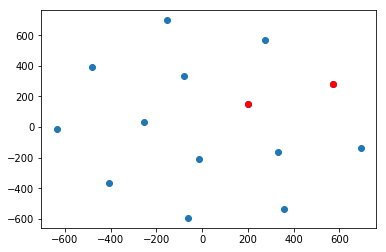

In [24]:
plt.scatter(X_r[:,0], X_r[:,1])
for i, name in enumerate(match_wise['designation']):
    for galaxyname in galaxy['designation']:
        if name == galaxyname:
            plt.scatter(X_r[i,0], X_r[i,1], color="red")  